# **Use this Notebook on Google Colab Free GPU**
Go to Google Drive, upload this notebook and dataset folders. Rigth click notebook, choose Open with -> Google Colab
To activate GPU in Colab, go to Runtime -> Change Runtime Type. Under Hardware accelerator choose GPU

# Connect to Google Drive to access Dataset
Data sets can be downloaded from: "https://www.kaggle.com/competitions/stat946winter2021/data"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unzip Dataset file and make covid/noncovid folders

In [2]:
# make data directories
import os
os.mkdir("/content/models")
os.mkdir("/content/unzipped")
os.mkdir("/content/data")
os.mkdir("/content/data/covid") 
os.mkdir("/content/data/nocovid") 

In [ ]:
# uzip the data set file
! unzip /content/drive/MyDrive/stat946winter2021.zip -d /content/unzipped/

In [4]:
# copy images to covid-noncovid folders
import shutil
from imutils import paths
import pandas as pd
from tqdm import tqdm

imagePaths = list(paths.list_images("unzipped/train"))
train_labels = pd.read_csv("unzipped/train_labels.csv")

for imagePath in tqdm(imagePaths):

    image_name = imagePath.split(os.path.sep)[-1]
    # find image lable in train_labels
    image_label = train_labels.loc[train_labels['File'] == image_name, 'Label'].iloc[0]
    if image_label == 1:
        shutil.copy(imagePath, "/content/data/covid")
    if image_label == 0:
        shutil.copy(imagePath, "/content/data/nocovid")
print()
print("# No covid images: ", len(list(paths.list_images("data/nocovid"))))
print("# covid images: ", len(list(paths.list_images("data/covid"))))

100%|██████████| 15264/15264 [00:21<00:00, 712.88it/s]



# No covid images:  13694
# covid images:  1570


In [5]:
# Split Data into train/Validation
!pip install split_folders
import splitfolders

splitfolders.ratio("/content/data", output='/content/data/splited', seed=1, ratio=(0.80, 0.2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 15264 files [00:02, 7194.71 files/s]


In [6]:
print('train data:')
print(len(list(paths.list_images("/content/data/splited/train/covid"))))
print(len(list(paths.list_images("/content/data/splited/train/nocovid"))))

print('Validation data:')
print(len(list(paths.list_images("/content/data/splited/val/covid"))))
print(len(list(paths.list_images("/content/data/splited/val/nocovid"))))

train data:
1256
10955
Validation data:
314
2739


# Visualize First 40 Images from Train Data set

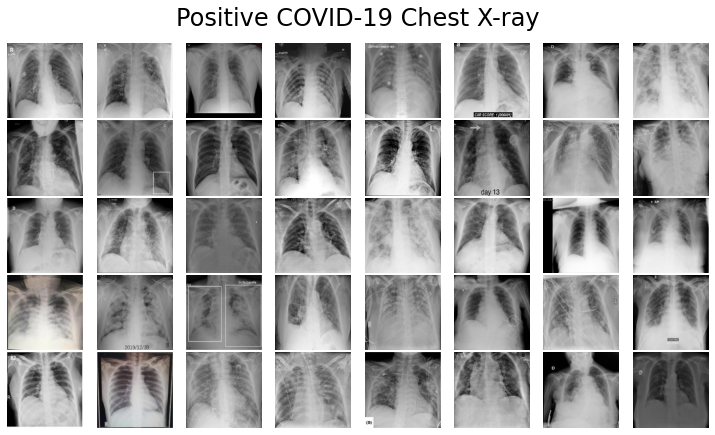

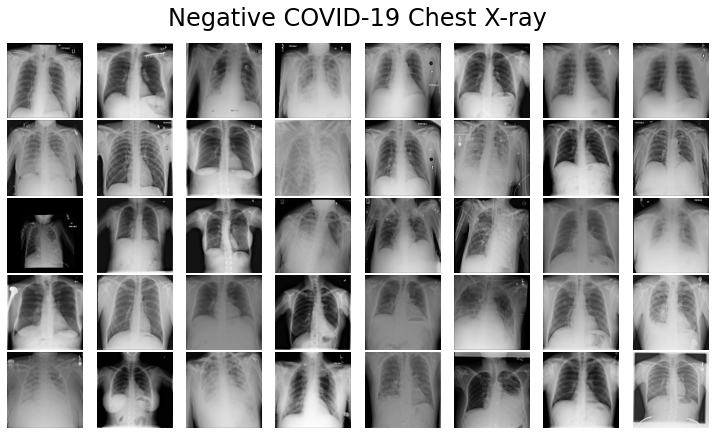

In [8]:
import matplotlib.pyplot as plt

def plot_images(img_folder_path, title):
    # Use glob to grab images from path .jpg or jpeg
    from glob import glob
    image_paths = glob(img_folder_path + '/*')

    # load first 40 images
    import cv2 
    images = []
    for i in range(40):
        image = cv2.imread(image_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(224,224))
        images.append(image)

    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

plot_images("/content/data/splited/train/covid", 'Positive COVID-19 Chest X-ray')
plot_images("/content/data/splited/train/nocovid", 'Negative COVID-19 Chest X-ray')

# Create data loader
Since all data cannot be loaded into memory at once, we need to create a data loader for train data and validation data to gradually feed the data for training. The data loader should also perform the required transformations such as grey scaling, converting to tensor (includes built-in normalization), and random horizontal flip (only for training). 

In [7]:
from torchvision import datasets, transforms
import torch

def create_data_loaders(train_path, valid_path, input_size, batch_size):
    # transformation for train data
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        ])

    # transformation for validation data
    transform_val = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        ])

    # define image folder objects
    TrainData      = datasets.ImageFolder(root=train_path, transform=transform_train)
    ValidationData = datasets.ImageFolder(root=valid_path, transform=transform_val)

    # define sample to oversample the minor class (nocovid)
    sampler = torch.utils.data.sampler.WeightedRandomSampler([1,8], num_samples=2, replacement=True)

    # define data loaders
    train_loader=torch.utils.data.DataLoader(TrainData, batch_size=batch_size, shuffle=sampler)
    val_loader=torch.utils.data.DataLoader(ValidationData, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Define Mixup data augmentation
In mixup, the virtual training feature-target samples are produced as,

x˜ = λxi + (1 − λ)xj

y˜ = λyi + (1 − λ)yj

where (xi, yi) and (xj, yj) are two feature-target samples drawn at random from the training data, λ∈[0, 1]. The mixup hyper-parameter α controls the strength of interpolation between feature-target pairs and λ∼Beta(α, α).

In [8]:
def mixup_data(x, y, alpha=0.5, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# Define Train and Evaluate Functions

In [18]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score 

criterion = nn.CrossEntropyLoss()

def train(model, dataloader, device, loss_type='regular', epochs=30):
    # define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001, eps=0.0001/epochs)
    model.train()

    pred_list, label_list = np.array([]), np.array([])
    running_loss = 0
    total_steps = 0

    for i, (images, labels) in tqdm(enumerate(dataloader)):
        images = images.to(device)
        labels = labels.to(device)
    
        optimizer.zero_grad()
        
        inputs, targets_a, targets_b, lam = mixup_data(images, labels, 0.5, True)
        inputs, targets_a, targets_b = map(Variable, (inputs, targets_a, targets_b))

        output = model(inputs)[0]
        prd = output.argmax(1)

        if loss_type == "weighted":
            loss = F.cross_entropy(output, labels, weight=torch.FloatTensor([1,2]).to(device))
        if loss_type == "mixup":
            loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        else:
            loss = F.cross_entropy(output, labels)
        
        # model learns by backpropagating
        loss.backward()
        
        # model optimizes its weights
        optimizer.step()
        
        # running train loss
        running_loss += loss.item()
        
        # get labels and predictions
        label_list= np.append(label_list, labels.cpu().numpy())
        pred_list = np.append(pred_list, prd.cpu().numpy())

        total_steps += 1
    
    epoch_loss = running_loss / total_steps
    epoch_acc = accuracy_score(label_list, pred_list)
    return epoch_loss, epoch_acc
    
def evaluate(model, dataloader, device):
    model.eval()
    valid_loss = 0
    pred_list, label_list = np.array([]), np.array([])

    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(dataloader)):
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            valid_loss += F.cross_entropy(output, labels, reduction='sum').item()

            prd = output.argmax(1)
            label_list= np.append(label_list, labels.cpu().numpy())
            pred_list = np.append(pred_list, prd.cpu().numpy())

    valid_loss /= len(dataloader.dataset)
    valid_acc = accuracy_score(label_list, pred_list)
    valid_f1 = f1_score(label_list, pred_list)
    valid_recall = recall_score(label_list, pred_list)
    valid_precision = precision_score(label_list, pred_list)
    return valid_loss, valid_acc, valid_f1, valid_recall, valid_precision, pred_list, label_list

# Load and visualize a pre-trained model

In [10]:
import torchvision.models as models
from collections import OrderedDict

def set_parameter_requires_grad(model, feature_extracting):
    '''
    This helper function sets the .requires_grad attribute of the parameters in 
    the model to False when we are feature extracting. By default, when we load a 
    pretrained model all of the parameters have .requires_grad=True, which is fine 
    if we are training from scratch or finetuning. However, if we are feature 
    extracting and only want to compute gradients for the newly initialized layer 
    then we want all of the other parameters to not require gradients. 
    '''
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

# Fine-tune the model

In [11]:
# Initialize the model for this run
model_name = 'inception'
num_classes = 2
feature_extract = False    # we are finetunning

model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
epochs, batch_size = 5, 32
loss_type='mixup'

seed = 42
save_model_path = "/content/models/"
train_path = "/content/data/splited/train"
valid_path = "/content/data/splited/val"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Cuda available: ", torch.cuda.is_available())
print("Current device: ", torch.cuda.current_device())

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed)
model.to(device)

In [15]:
# create data loaders:
train_loader, val_loader = create_data_loaders(train_path, valid_path, input_size, batch_size)

loss_list = []
acc_list = []
for e in range(1, epochs+1):
    print(f"\nepoch {e}/{epochs}")

    train_loss, train_acc = train(model, train_loader, device, loss_type)
    print(f"Train loss = {train_loss:.{2}f}, acc: {train_loss:.{2}f}")

    valid_loss, val_acc, val_f1, val_recall, val_precision, _, _ = evaluate(model, val_loader, device)
    loss_list.append([train_loss, valid_loss])
    acc_list.append([train_acc, val_acc])

    torch.save(model, save_model_path + 'model_e'+ str(e)+ '.pt')

    print()
    print(f"Val loss: {valid_loss:.{2}f} - Acc: {val_acc:.{2}f} - f1: {val_f1:.{2}f} - recall: {val_recall:.{2}f} - precision: {val_precision:.{2}f}")



epoch 1/5


382it [03:03,  2.09it/s]


Train loss = 0.19, acc: 0.19


96it [00:26,  3.62it/s]



Val loss: 0.11 - Acc: 0.97 - f1: 0.98 - recall: 0.99 - precision: 0.97

epoch 2/5


382it [03:02,  2.10it/s]


Train loss = 0.19, acc: 0.19


96it [00:26,  3.64it/s]



Val loss: 0.09 - Acc: 0.97 - f1: 0.98 - recall: 0.99 - precision: 0.97

epoch 3/5


382it [03:02,  2.10it/s]


Train loss = 0.18, acc: 0.18


96it [00:26,  3.64it/s]



Val loss: 0.10 - Acc: 0.97 - f1: 0.98 - recall: 1.00 - precision: 0.97

epoch 4/5


382it [03:02,  2.10it/s]


Train loss = 0.17, acc: 0.17


96it [00:26,  3.63it/s]



Val loss: 0.13 - Acc: 0.95 - f1: 0.97 - recall: 1.00 - precision: 0.95

epoch 5/5


382it [03:02,  2.10it/s]


Train loss = 0.16, acc: 0.16


96it [00:26,  3.63it/s]



Val loss: 0.14 - Acc: 0.95 - f1: 0.97 - recall: 1.00 - precision: 0.95


# Evalute the model (ROC, Confusion matrix)

In [25]:
# load the model
model = torch.load("/content/models/model_e1.pt")  

# get the predictions
_, _, _, _, _, preds, labels = evaluate(model, val_loader, device)

96it [00:28,  3.42it/s]


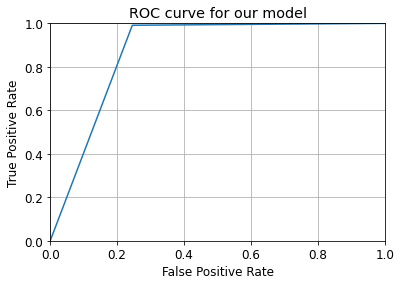

In [26]:
# ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, preds)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


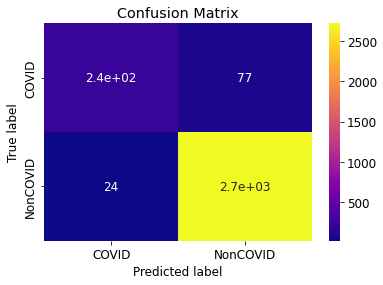

Confusion Matrix with Normalized Values


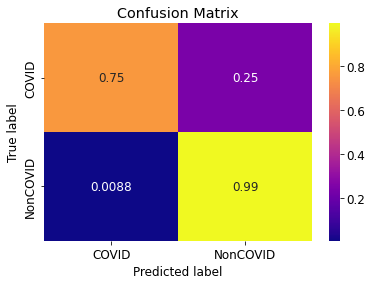

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(labels, preds, normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [28]:
from sklearn.metrics import classification_report
print(classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82       314
         1.0       0.97      0.99      0.98      2739

    accuracy                           0.97      3053
   macro avg       0.94      0.87      0.90      3053
weighted avg       0.97      0.97      0.97      3053



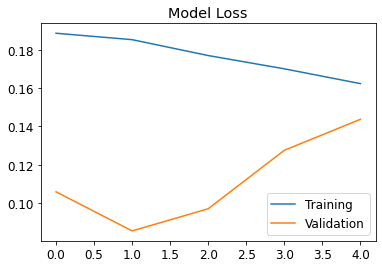

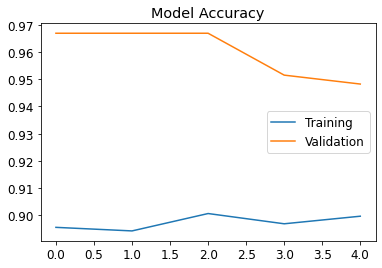

In [34]:
# loss vs epoch
plt.plot(loss_list)
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.show()

# accuracy vs epoch
plt.plot(acc_list)
plt.title('Model Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()